XAI Implementation - LRP 

Is CUDA available? True
Running on: cuda
Starting training...
Epoch 1/10 - Loss: 0.9162
Epoch 2/10 - Loss: 0.3875
Epoch 3/10 - Loss: 0.2518
Epoch 4/10 - Loss: 0.1810
Epoch 5/10 - Loss: 0.1279
Epoch 6/10 - Loss: 0.0877
Epoch 7/10 - Loss: 0.0522
Epoch 8/10 - Loss: 0.0481
Epoch 9/10 - Loss: 0.0280
Epoch 10/10 - Loss: 0.0195
Training finished.
Batch accuracy:  0.78125
   labels  outputs
0       3        3
1       2        2
2       0        1
3       1        1
4       3        3


C:\Users\AY\AppData\Local\Temp\ipykernel_29632\382102446.py:195: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  activations[-1] = torch.tensor([one_hot_output], dtype=torch.float32).to(device)
C:\Users\AY\AppData\Local\Temp\ipykernel_29632\382102446.py:195: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:281.)
  activations[-1] = torch.tensor([one_hot_output], dtype=torch.float32).to(device)


Groundtruth: pituitary_tumor


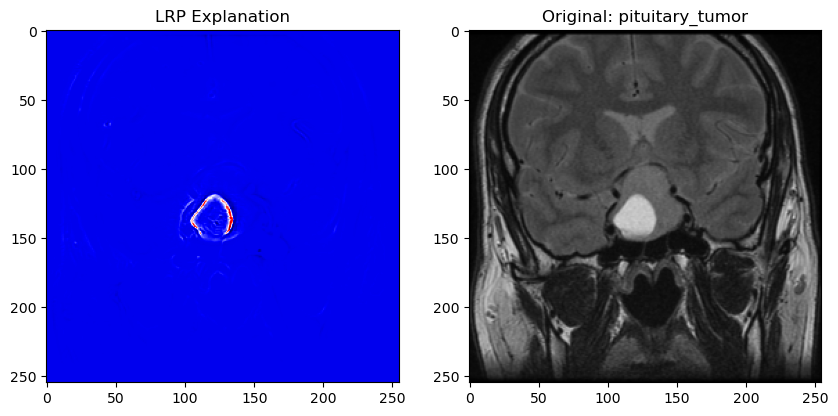

In [1]:
# %% Imports
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import copy
import pandas as pd 

#device setup
print(f"Is CUDA available? {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")


# Load data
TRAIN_ROOT = "data/brain_mri/training"
TEST_ROOT = "data/brain_mri/testing"


#Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Use weights instead of pretrained=True (New PyTorch standard)
        self.vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT) 

        # Replace output layer according to our problem
        in_feats = self.vgg16.classifier[6].in_features 
        self.vgg16.classifier[6] = nn.Linear(in_feats, 4)

    def forward(self, x):
        x = self.vgg16(x)
        return x

model = CNNModel()
model.to(device)


# prepare data
# Add data augmentation to prevent overfit 
train_transform = transforms.Compose([
    transforms.Resize((255,255)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((255,255)),
    transforms.ToTensor()
])

try:
    train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_ROOT, transform=train_transform)
    test_dataset = torchvision.datasets.ImageFolder(root=TEST_ROOT, transform=test_transform)
except FileNotFoundError:
    print("WARNING: Data folders not found. Please check TRAIN_ROOT and TEST_ROOT paths.")

#data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)


# Train
cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
epochs = 10

print("Starting training...")
for epoch in range(epochs):  
    running_loss = 0.0
    for i, batch in enumerate(train_loader, 0):
        inputs, labels = batch
        
        # CRITICAL: Move data to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = cross_entropy_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss / len(train_loader):.4f}")

print("Training finished.")


# %% Inspect predictions for first batch
inputs, labels = next(iter(test_loader))

# Move test inputs to GPU
inputs = inputs.to(device)
# Keep labels on CPU for pandas comparison later (or move back to cpu)
labels_np = labels.numpy() 

# Get predictions (move back to CPU for numpy conversion)
outputs = model(inputs).max(1).indices.detach().cpu().numpy()

comparison = pd.DataFrame()
print("Batch accuracy: ", (labels_np==outputs).sum()/len(labels_np))
comparison["labels"] = labels_np
comparison["outputs"] = outputs
print(comparison.head())


#LRP
def new_layer(layer, g):
    layer = copy.deepcopy(layer)
    try: layer.weight = torch.nn.Parameter(g(layer.weight))
    except AttributeError: pass
    try: layer.bias = torch.nn.Parameter(g(layer.bias))
    except AttributeError: pass
    return layer

#Convert dense to convolutional layer 
def dense_to_conv(layers):
    newlayers = []
    for i,layer in enumerate(layers):
        if isinstance(layer, nn.Linear):
            newlayer = None
            if i == 0:
                m, n = 512, layer.weight.shape[0]
                newlayer = nn.Conv2d(m,n,7)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,7,7))
            else:
                m,n = layer.weight.shape[1],layer.weight.shape[0]
                newlayer = nn.Conv2d(m,n,1)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,1,1))
            
            newlayer.bias = nn.Parameter(layer.bias)
            
            newlayer = newlayer.to(layer.weight.device)
            
            newlayers += [newlayer]
        else:
            newlayers += [layer]
    return newlayers

def get_linear_layer_indices(model):
    offset = len(model.vgg16._modules['features']) + 1
    indices = []
    for i, layer in enumerate(model.vgg16._modules['classifier']): 
        if isinstance(layer, nn.Linear): 
            indices.append(i)
    indices = [offset + val for val in indices]
    return indices

def apply_lrp_on_vgg16(model, image):
    # Ensure image is on the correct device
    image = image.to(device)
    image = torch.unsqueeze(image, 0)
    
    # Extract layers
    layers = list(model.vgg16._modules['features']) \
                + [model.vgg16._modules['avgpool']] \
                + dense_to_conv(list(model.vgg16._modules['classifier']))
    linear_layer_indices = get_linear_layer_indices(model)
    
    #Propagate image through layers and store activations
    n_layers = len(layers)
    activations = [image] + [None] * n_layers # list of activations
    
    for layer in range(n_layers):
        if layer in linear_layer_indices:
            if layer == 32:
                activations[layer] = activations[layer].reshape((1, 512, 7, 7))
        activation = layers[layer].forward(activations[layer])
        if isinstance(layers[layer], torch.nn.modules.pooling.AdaptiveAvgPool2d):
            activation = torch.flatten(activation, start_dim=1)
        activations[layer+1] = activation

    #Replace last layer with one-hot-encoding
    output_activation = activations[-1].detach().cpu().numpy()
    max_activation = output_activation.max()
    one_hot_output = [val if val == max_activation else 0 
                        for val in output_activation[0]]

    # Create tensor directly on device
    activations[-1] = torch.tensor([one_hot_output], dtype=torch.float32).to(device)

    #Backpropagate relevance scores
    relevances = [None] * n_layers + [activations[-1]]
    for layer in range(0, n_layers)[::-1]:
        current = layers[layer]
        if isinstance(current, torch.nn.MaxPool2d):
            layers[layer] = torch.nn.AvgPool2d(2)
            current = layers[layer]
        if isinstance(current, torch.nn.Conv2d) or \
           isinstance(current, torch.nn.AvgPool2d) or\
           isinstance(current, torch.nn.Linear):
            activations[layer] = activations[layer].data.requires_grad_(True)
            
            # Apply variants of LRP depending on the depth
            # Lower layers, LRP-gamma >> Favor positive contributions (activations)
            if layer <= 16:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
            
            # Middle layers, LRP-epsilon >> Remove some noise / Only most salient factors survive
            if 17 <= layer <= 30: rho = lambda p: p;                        incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
            
            # Upper Layers, LRP-0 >> Basic rule
            if layer >= 31:       rho = lambda p: p;                        incr = lambda z: z+1e-9
            
            # Transform weights of layer and execute forward pass
            z = incr(new_layer(layers[layer],rho).forward(activations[layer]))
            
            # Element-wise division between relevance of the next layer and z
            s = (relevances[layer+1]/z).data  
            
            # Calculate the gradient and multiply it by the activation
            (z * s).sum().backward(); 
            c = activations[layer].grad       
            # Assign new relevance values            
            relevances[layer] = (activations[layer]*c).data  
            
        else:
            relevances[layer] = relevances[layer+1]

    return relevances[0]

#Calculate relevances for first image in this test batch
image_id = 0 
image_relevances = apply_lrp_on_vgg16(model, inputs[image_id])

#Visualization handling
image_relevances = image_relevances.permute(0,2,3,1).detach().cpu().numpy()[0]
image_relevances = np.interp(image_relevances, (image_relevances.min(),
                                                image_relevances.max()), 
                                                (0, 1))

# Show relevances
pred_label = list(test_dataset.class_to_idx.keys())[
             list(test_dataset.class_to_idx.values())
            .index(labels_np[image_id])]

print(f"Groundtruth: {pred_label}")

# Plot images next to each other
plt.figure(figsize=(10, 5))
plt.axis('off')
plt.subplot(1,2,1)
plt.title("LRP Explanation")
plt.imshow(image_relevances[:,:,0], cmap="seismic")
plt.subplot(1,2,2)
plt.title(f"Original: {pred_label}")

# Move original image back to CPU for plotting
plt.imshow(inputs[image_id].permute(1,2,0).detach().cpu().numpy())
plt.show()

Total Relevance in Image: 17770.83
Relevance inside Tumor ROI: 1793.53
Region Relevance Score: 10.09%
Interpretation: 10.09% of the model's attention is focused inside the tumor region.


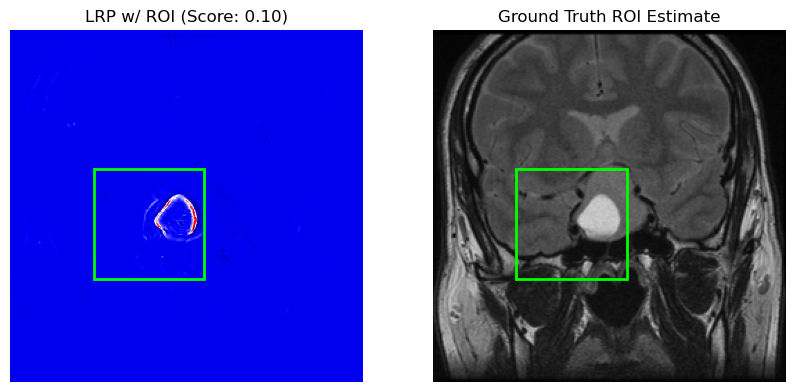

In [2]:
#Bonus: Region Relevance Score
import matplotlib.patches as patches

def calculate_region_relevance(relevance_map, bbox):
    x, y, w, h = bbox
    roi_relevance = relevance_map[y:y+h, x:x+w]
    
    # Sum of relevance inside the box
    sum_roi = np.sum(np.abs(roi_relevance))
    
    # Sum of relevance in the entire image
    sum_total = np.sum(np.abs(relevance_map))
    
    # Avoid division by zero
    if sum_total == 0:
        return 0.0
        
    score = sum_roi / sum_total
    return score

#Define tumor box 
tumor_bbox = (60, 100, 80, 80) 

#calculate score
heatmap_2d = image_relevances[:,:,0]

relevance_score = calculate_region_relevance(heatmap_2d, tumor_bbox)

print(f"Total Relevance in Image: {np.sum(np.abs(heatmap_2d)):.2f}")
print(f"Relevance inside Tumor ROI: {np.sum(np.abs(heatmap_2d[tumor_bbox[1]:tumor_bbox[1]+tumor_bbox[3], tumor_bbox[0]:tumor_bbox[0]+tumor_bbox[2]])):.2f}")
print(f"Region Relevance Score: {relevance_score * 100:.2f}%")
print("Interpretation: {:.2f}% of the model's attention is focused inside the tumor region.".format(relevance_score * 100))

#Visualize box 
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot LRP with Box
ax[0].imshow(heatmap_2d, cmap="seismic")
rect = patches.Rectangle((tumor_bbox[0], tumor_bbox[1]), tumor_bbox[2], tumor_bbox[3], 
                         linewidth=2, edgecolor='lime', facecolor='none')
ax[0].add_patch(rect)
ax[0].set_title(f"LRP w/ ROI (Score: {relevance_score:.2f})")
ax[0].axis('off')

# Plot Original with Box
ax[1].imshow(inputs[image_id].permute(1,2,0).detach().cpu().numpy())
rect2 = patches.Rectangle((tumor_bbox[0], tumor_bbox[1]), tumor_bbox[2], tumor_bbox[3], 
                          linewidth=2, edgecolor='lime', facecolor='none')
ax[1].add_patch(rect2)
ax[1].set_title(f"Ground Truth ROI Estimate")
ax[1].axis('off')

plt.show()

Task 3: XAI Implementation - Grad-CAM

In [3]:
# Run this cell once to fix the RuntimeError
# Loop through all layers in the model
for module in model.modules():
    if isinstance(module, nn.ReLU):
        module.inplace = False

print("Model patched: In-place ReLU disabled. You can now run Grad-CAM.")

Model patched: In-place ReLU disabled. You can now run Grad-CAM.


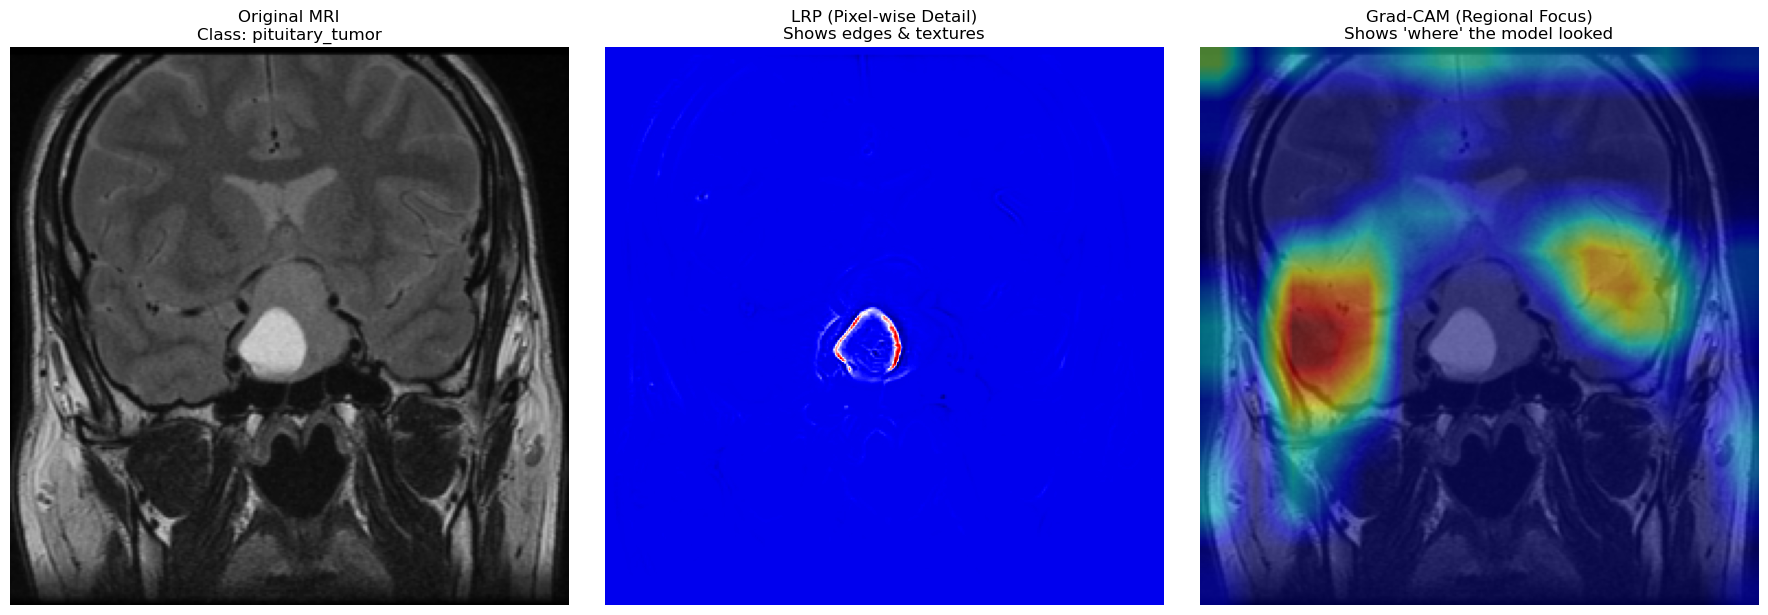

In [4]:
import torch.nn.functional as F
import cv2 

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_image, class_index=None):
        self.model.zero_grad()
        output = self.model(input_image)

        if class_index is None:
            class_index = torch.argmax(output)

        one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_().to(device)
        one_hot_output[0][class_index] = 1
        output.backward(gradient=one_hot_output, retain_graph=True)

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        
        activation = self.activations.detach()
        for i in range(activation.shape[1]):
            activation[:, i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(activation, dim=1).squeeze()

        heatmap = F.relu(heatmap)
        
        if torch.max(heatmap) != 0:
            heatmap /= torch.max(heatmap)
            
        return heatmap.cpu().numpy()

#Setup Grad-CAM

target_layer = model.vgg16.features[-3] 
grad_cam = GradCAM(model, target_layer)

# Run Grad-CAM on the same image used for LRP for better comparison
input_tensor = inputs[image_id].unsqueeze(0).to(device)

# Generate heatmap
cam_heatmap = grad_cam.generate(input_tensor, class_index=None)

# Resize Heatmap to match original image size (255x255)
cam_heatmap_resized = F.interpolate(
    torch.tensor(cam_heatmap).view(1, 1, cam_heatmap.shape[0], cam_heatmap.shape[1]),
    size=(255, 255),
    mode='bilinear',
    align_corners=False
).squeeze().numpy()

#Plot orginal MRI, LRP and Grad-cam
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title(f"Original MRI\nClass: {pred_label}")
plt.imshow(inputs[image_id].permute(1,2,0).detach().cpu().numpy())
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("LRP (Pixel-wise Detail)\nShows edges & textures")
plt.imshow(image_relevances[:,:,0], cmap="seismic")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Grad-CAM (Regional Focus)\nShows 'where' the model looked")

plt.imshow(inputs[image_id].permute(1,2,0).detach().cpu().numpy())

plt.imshow(cam_heatmap_resized, cmap='jet', alpha=0.5) 
plt.axis('off')

plt.tight_layout()
plt.show()

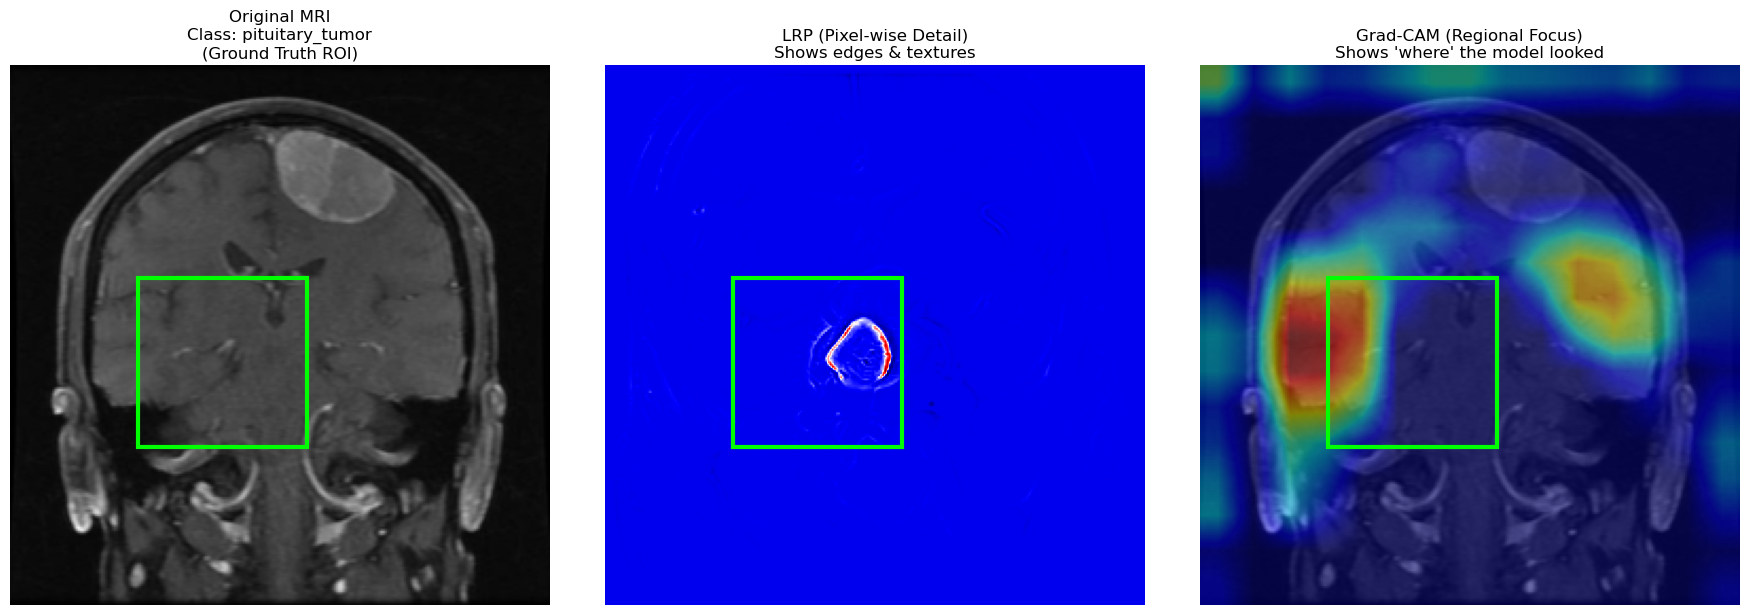

In [13]:
plt.figure(figsize=(18, 6))

# Original mri with green box 
plt.subplot(1, 3, 1)
plt.title(f"Original MRI\nClass: {pred_label}\n(Ground Truth ROI)")
plt.imshow(inputs[image_id].permute(1,2,0).detach().cpu().numpy())
plt.gca().add_patch(create_green_box(tumor_bbox))
plt.axis('off')

# lrp with green box 
plt.subplot(1, 3, 2)
plt.title("LRP (Pixel-wise Detail)\nShows edges & textures")
plt.imshow(image_relevances[:,:,0], cmap="seismic") 
plt.gca().add_patch(create_green_box(tumor_bbox))
plt.axis('off')

# grad-cam with green box 
plt.subplot(1, 3, 3)
plt.title("Grad-CAM (Regional Focus)\nShows 'where' the model looked")
plt.imshow(inputs[image_id].permute(1,2,0).detach().cpu().numpy())
plt.imshow(cam_heatmap_resized, cmap='jet', alpha=0.5)
plt.gca().add_patch(create_green_box(tumor_bbox))
plt.axis('off')

plt.tight_layout()
plt.show()

In [14]:
import numpy as np

def calculate_region_relevance(relevance_map, bbox):
    x, y, w, h = bbox
    roi = relevance_map[y:y+h, x:x+w]
    
    sum_roi = np.sum(np.abs(roi))
    sum_total = np.sum(np.abs(relevance_map))
    
    if sum_total == 0: return 0.0
    return sum_roi / sum_total

gradcam_score = calculate_region_relevance(cam_heatmap_resized, tumor_bbox)

roi_relevance_cam = cam_heatmap_resized[tumor_bbox[1]:tumor_bbox[1]+tumor_bbox[3], 
                                        tumor_bbox[0]:tumor_bbox[0]+tumor_bbox[2]]
sum_roi_cam = np.sum(np.abs(roi_relevance_cam))
sum_total_cam = np.sum(np.abs(cam_heatmap_resized))

print("Grad-cam region relevance score:")
print(f"Total Activation in Image: {sum_total_cam:.2f}")
print(f"Activation inside Tumor ROI: {sum_roi_cam:.2f}")
print(f"Region Relevance Score: {gradcam_score * 100:.2f}%")
print("Interpretation: {:.2f}% of the model's Grad-CAM focus is inside the tumor region.".format(gradcam_score * 100))

Grad-cam region relevance score:
Total Activation in Image: 9431.08
Activation inside Tumor ROI: 1393.18
Region Relevance Score: 14.77%
Interpretation: 14.77% of the model's Grad-CAM focus is inside the tumor region.


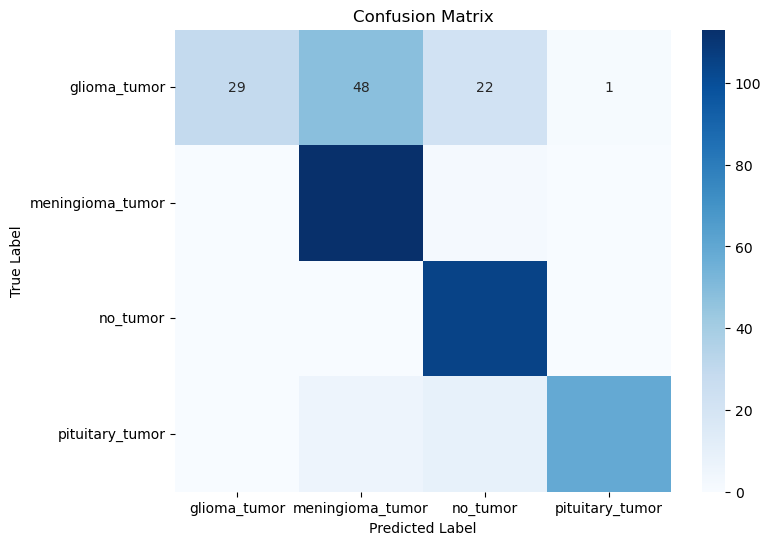

CRITICAL ERROR ANALYSIS:
The model missed 33 tumors (classified them as healthy).


In [15]:
# BONUS: Calculate False Positives & Negatives (Confusion Matrix)
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

#generate confusion matrix 
classes = test_dataset.classes
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

try:
    no_tumor_idx = test_dataset.class_to_idx['no_tumor']

    false_negatives = sum(cm[:, no_tumor_idx]) - cm[no_tumor_idx, no_tumor_idx]
    
    print(f"CRITICAL ERROR ANALYSIS:")
    print(f"The model missed {false_negatives} tumors (classified them as healthy).")
except KeyError:
    print("Could not automatically find 'no_tumor' class index. Please check class names.")